In [1]:
import numpy as np
import pandas as pd

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Input, Dropout

from keras.layers import concatenate
from keras.utils import to_categorical

Using TensorFlow backend.


In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

## Loading Data

In [2]:
# import helper_save_load
# df = helper_save_load.load_excel_spreadsheet("../Commentaries_labeled_v2.xlsm", "SplitComments")


# brands_df = helper_save_load.load_excel_spreadsheet("../brands-categories-totals-updated.xlsx", "Brands-processed")
# brands_df.rename(columns={"Brands in Commentaries file":"Brand"}, inplace=True)

# # Merges on Brand but also gets rid of all Total category rows
# df = df.merge(brands_df[["Brand", "Brand_1", "Brand_2", "Brand_3"]], on=["Brand"])
# df.sort_values(by=["Num"], inplace=True)
# helper_save_load.save_to_pickle("Labeled_comments.pkl", df)

In [86]:
from helper_save_load import load_from_pickle

df_c = load_from_pickle("Labeled_comments.pkl")
#dfc.dropna(subset=['Brand'], inplace=True)

In [79]:
ignored_brands = ["57-CAMAY BAR SOAP Brand",
"IGNORE",
"71-LBP SH/CD Roll-up Brand",
"72-LBP SHOWER Roll-up Brand"]

df_c = df_c[~df_c["Brand_1"].isin(ignored_brands)]

In [80]:
label_cols = df_c.columns[12:16] # Don't include Baseline for now

territory_label_cols = df_c.columns[17:]
territory_labels = df_c[territory_label_cols]

In [63]:
# Undersample
no_label = df_c[label_cols].sum(axis=1) == 0

df_class_0 = df_c[no_label]
df_class_1 = df_c[~no_label]

count_class_0 = len(df_class_0)
count_class_1 = len(df_class_1)

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

df_c = df_test_under.sort_values(by='Num').reset_index(drop=True)

In [81]:
labels = df_c[label_cols] 

In [51]:
df_a, df_f, df_v = load_from_pickle("dataframes_Dollars.pickle")
del df_a, df_f

## Preparing Data

In [2]:
df_c["Month"] = pd.to_datetime(df_c["Month"]).dt.strftime("%b_%Y")

df_c["Commentaries"] = df_c["Commentaries"].str.replace("\$?[0-9\.]+[MK]","[#]")
df_c["Commentaries"] = df_c["Commentaries"].str.replace("[,/]", " ")
df_c["Commentaries"] = df_c["Commentaries"].str.replace('[!"$%&\'()*:;<=>?@\\.^_`{|}~]', '')
df_c["Commentaries"] = df_c["Commentaries"].str.lower()

commentaries = "[SOS] " + df_c["Commentaries"] + " [EOS]"
commentaries.fillna("[SOS] [EOS]", inplace=True)
commentaries.head(7)

In [1]:
df_c.head()

In [10]:
territories = [territory for territory, values in df_v.groupby(['Territory']).groups.items()]

In [11]:
empty_df = pd.DataFrame(0.0, index=[0], columns=territories)
varv_length = len(empty_df.columns)

In [12]:
#return pivot table for the required month in Millions of $
def get_pivot_month_Territory_by_brand(month, brand, flatten=1):
    #Group by Territory and Brand
    df_group_Br_Tr = df_v[df_v['Brand'] == brand].groupby(['Brand', 'Territory']).sum()
    result = pd.pivot_table(df_group_Br_Tr, values=[month], index=['Brand'], 
                            columns=['Territory'], aggfunc=np.sum, fill_value=0) / 1e6
    result.columns = result.columns.droplevel()  #drop month level as there is only one month
    if len(result.index)>0:   #if no data is available, return a zero vector
    #Align with empty_df that includes all territories
        result = empty_df.append(result, sort=True).fillna(0)      
        result.drop(0, inplace=True)  #drop line 0 of empty_df
    else:
        result = empty_df 
    if (flatten==1): result = result.values.flatten()
    return (result)  

get_pivot_month_Territory_by_brand('Jan_2018', '05-AXE SA Brand', 0)

,M1000 - E-COMMERCE,M4000 - LCL HPC,M4001 - LCL FDS exclude IC,M4002 - LCL IC,M4400 - SHOPPERS D.M.,M5000 - MCKESSON,M5001 - JEAN COUTU,M5002 - FAMILIPRIX,M5100 - METRO ONT IC,M5101 - METRO QUE IC,...,M7303 - NATIONAL OOH MDs,M7304 - ATLANTIC RETAIL AND OOH,M7305 - COUCHE TARD,M7400 - WALMART,M7500 - CANADA COSTCO,M7600 - GIANT TIGER,M7601 - DOLLAR VALUE,M7602 - LONGOS,M7603 - ALTERNATIVE CHANNELS,M7700 - ONT/WEST FIELD
05-AXE SA Brand,0.002027,0.001381,0.0,0.0,-0.000094,0.01371,-0.000699,-0.001275,0.0,0.0,...,0.0,0.0,0.0,0.005972,0.0,0.0,0.0,0.0,0.0,-0.000208


# Update for single Territory input

## Reshaping Data

In [14]:
# We want a 12 month window of variance data for each commentary

# Get full time series for each brand.
# -> Lookup month-brand for your commentary and append

brands = df_v["Brand"].unique()
months = np.array(df_v.columns[8:])

var_timeseries = []

for brand in brands:
    temp = []
    for month in months:
        temp.append(get_pivot_month_Territory_by_brand(month, brand))
                        
    var_timeseries.append(temp)

var_timeseries = np.array(var_timeseries)

In [15]:
var_timeseries.shape # Brands by month by territory. LSTM will be fed month rows for the brand involved

(136, 34, 34)

In [16]:
# Function to choose data from 1 year window per commentary. Pad with zeros if data not available.

# Needs rework?
timeseries_windows = []
for (index, row) in df_c[["Month", "Brand_1"]].iterrows():
    brand_idx = np.where(brands==row["Brand_1"])[0][0]
    month_idx = np.where(months==row["Month"])[0][0]
    
    if month_idx - 12 < 0:
        # Maybe pad with something other than zeros??
        padding = np.zeros(((12 - month_idx), len(territories)))
        window = np.concatenate((padding, var_timeseries[brand_idx, :month_idx, :]))
    else:
        window = var_timeseries[brand_idx, (month_idx-12):month_idx, :]
    
    timeseries_windows.append(window)
    
timeseries_windows = np.array(timeseries_windows)

In [134]:
timeseries_windows.shape # 1294 commentaries x 12 months x 34 territories

(1294, 12, 34)

## Build the Model

In [135]:
def show_image(imagefile, w, h):
    %pylab inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img=mpimg.imread(imagefile)
    plt.figure(figsize=(w, h))
    imgplot = plt.imshow(img);
    plt.show();

def show_model(model, w, h):
    from keras.utils.vis_utils import plot_model
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True);
    show_image('model_plot.png', w, h)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
BrandVarianceWindows (InputL (None, 12, 34)            0         
_________________________________________________________________
VarianceLSTM (LSTM)          (None, 200)               188000    
_________________________________________________________________
ClassOutputs (Dense)         (None, 4)                 804       
Total params: 188,804
Trainable params: 188,804
Non-trainable params: 0
_________________________________________________________________
None
Populating the interactive namespace from numpy and matplotlib


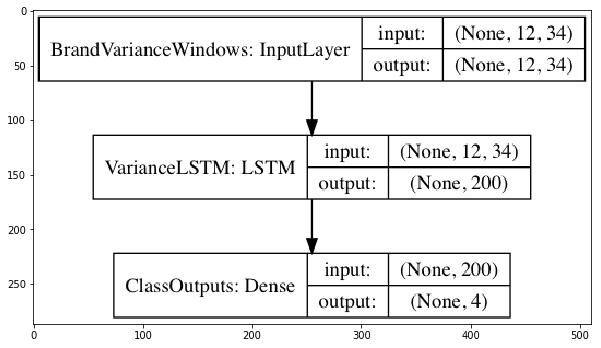

In [136]:
# LSTM that takes windowed time series of variance by brand per commentary

inputs = Input(shape=(12,34), name="BrandVarianceWindows")
lstm = LSTM(200, name="VarianceLSTM")
lstm_outputs = lstm(inputs)

class_outputs = Dense(4, activation='sigmoid', name="ClassOutputs")(lstm_outputs)

model = Model(inputs, class_outputs)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())
show_model(model, 10, 10)

In [137]:
labels.fillna(0, inplace=True)
targets = labels.values

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [138]:
# nonzero_idx = np.nonzero(targets)[0]

history = model.fit(x=timeseries_windows[:], y=targets[:], epochs=10)
#history = model.fit(x=timeseries_windows[:], y=targets[:], epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1294/1294 [==============================] - 3s 2ms/step - loss: 0.2451 - acc: 0.9436
Epoch 2/10
1294/1294 [==============================] - 1s 911us/step - loss: 0.1776 - acc: 0.9529
Epoch 3/10
1294/1294 [==============================] - 1s 940us/step - loss: 0.1741 - acc: 0.9536
Epoch 4/10
1294/1294 [==============================] - 1s 942us/step - loss: 0.1724 - acc: 0.9538 1s - loss: 0.
Epoch 5/10
1294/1294 [==============================] - 1s 881us/step - loss: 0.1698 - acc: 0.9521
Epoch 6/10
1294/1294 [==============================] - 1s 892us/step - loss: 0.1695 - acc: 0.9534
Epoch 7/10
1294/1294 [==============================] - 1s 889us/step - loss: 0.1664 - acc: 0.9531
Epoch 8/10
1294/1294 [==============================] - 1s 905us/step - loss: 0.1649 - acc: 0.9540
Epoch 9/10
1294/1294 [==============================] - 1s 880us/step - loss: 0.1629 - acc: 0.9542
Epoch 10/10
1294/1294 [==============================] - 1s 950us/step - loss: 0.1619 - acc: 0.95

KeyError: 'val_loss'

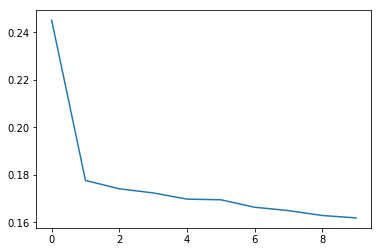

In [139]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('model loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('model accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [140]:
def prediction_accuracy(var_test, test_labels):
    predictions = model.predict(var_test)
    
    correct = sum(np.all(np.equal(np.round(predictions),test_labels), axis=1))
    
    return correct/len(test_labels)

In [141]:
targets.shape

(1294, 4)

In [142]:
prediction_accuracy(timeseries_windows, targets)

0.8431221020092736

In [143]:
test = model.predict(timeseries_windows)

In [144]:
nonzero_idx = np.nonzero(targets)[0]

In [145]:
np.sum(targets, axis=0)

array([ 88., 112.,  22.,  18.])

In [146]:
np.sum(np.round(test), axis=0)

array([33.,  3.,  0.,  0.], dtype=float32)

In [39]:
label_cols

Index(['Promo', 'Phasing', 'SP&D', 'POS'], dtype='object')

## Exploration

In [3]:
df_c[df_c["Commentaries"].str.contains("phas", na=False)]

In [4]:
df_c[(df_c["WM"] == 1) & (df_c["Commentaries"].str.contains("phas", na=False))][["Month", "Brand_1", "Variance", "Commentaries"]]

In [5]:
df_c[(df_c["WM"] == 1) & (df_c["Brand_1"] == "JK-DOVE HS-SA Brand")][["Month", "Brand_1", "Commentaries"]]

In [85]:
wm_actual = df_a.groupby(["Territory", "Brand"]).sum().loc["M7400 - WALMART"]
wm_forecast=df_f.groupby(["Territory", "Brand"]).sum().loc["M7400 - WALMART"]
wm_actual.columns = wm_by_brand.columns
wm_forecast.columns = wm_by_brand.columns

In [34]:
df_group_Tr_Br = df_v.groupby(["Territory", "Brand"]).sum()

In [49]:
wm_by_brand = df_group_Tr_Br.loc["M7400 - WALMART"]

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(wm_actual.loc["JK-DOVE HS-SA Brand"], label="Actual")
plt.plot(wm_forecast.loc["JK-DOVE HS-SA Brand"], label="Forecast")
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.title(wm_actual.loc["JK-DOVE HS-SA Brand"].name, fontsize=24)
plt.grid(axis='x')

plt.legend(fontsize=18)
plt.show()


In [ ]:
plt.figure(figsize=(30,10))
plt.plot(wm_by_brand.loc["JK-DOVE HS-SA Brand"])

plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.title(wm_by_brand.loc["JK-DOVE HS-SA Brand"].name, fontsize=24)
plt.grid()

plt.show()


# plt.figure(figsize=(30,10))

# plt.xticks(rotation=90, fontsize=18)
# plt.yticks(fontsize=18)
# plt.title(wm_actual.loc["JK-DOVE HS-SA Brand"].name, fontsize=24)

# plt.plot(wm_actual.loc["JK-DOVE HS-SA Brand"])
# plt.show()

# plt.figure(figsize=(30,10))

# plt.xticks(rotation=90, fontsize=18)
# plt.yticks(fontsize=18)
# plt.title(wm_forecast.loc["JK-DOVE HS-SA Brand"].name, fontsize=24)

# plt.plot(wm_forecast.loc["JK-DOVE HS-SA Brand"])
# plt.show()